## Descriptive Analyses: how are users using their phone?

In [1]:
!pip install --upgrade matplotlib -q
!pip install --upgrade pandas -q
!pip install ipy mpl -q

ERROR: Could not find a version that satisfies the requirement mpl (from versions: none)
ERROR: No matching distribution found for mpl


In [2]:
class color:
   PURPLE, CYAN, DARKCYAN, BLUE = '\033[95m', '\033[96m', '\033[36m', '\033[94m'
   GREEN, YELLOW, RED, BOLD = '\033[92m', '\033[93m', '\033[91m','\033[1m'
   UNDERLINE, END = '\033[4m','\033[0m'

In [3]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import matplotlib.ticker as mtick
from string import ascii_letters
from scipy import stats
from sklearn import tree
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [4]:
demographics = pd.read_csv('Processed Data/demographics_15.csv')
demographics.rename(columns={'userid': 'id'}, inplace=True)
td_dataset = pd.read_stata('Raw Data/td_ita.dta')  #this version was filled - in with nan for unanswered timestamps. 
by_minute = pd.read_csv('Processed Data/by_minute_15_with_empty_obs.csv')
by_minute.touches = by_minute.touches.astype(int)
by_minute = by_minute.drop(columns="Unnamed: 0")

In [5]:
by_minute['timestamp'] = pd.to_datetime(by_minute.loc[:,'timestamp'])
by_minute.rename(columns={'userid': 'id'}, inplace=True)
dictdays = dict()
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

for i in range(0, 7):
    dictdays[i] = days[i]
by_minute.loc[:,"weekday"] = [days[i] for i in by_minute.timestamp.dt.weekday]
#dictdays[by_minute[by_minute.timestamp.dt.day == ].timestamp.head(1).dt.dayofweek.values[0]]
weekend_clock_days = [14, 15, 21, 22, 28]

#turning clock days to the observational time or "human days"
weekends = [by_minute[by_minute['timestamp'].dt.day == day].day.head(1).values[0] for day in weekend_clock_days]
print(weekends)  #the first weekend is 3 days into the observation. 
def today_or_yesterday(t): 
    if t < 0:
        return t + 24
    return t

[2, 3, 9, 10, 16]


Based on every time that an user said they were doing something, I need to find the activities that took the most time for them. 
Since my research question is about smartphone pervasiveness - how the smarthphone pervades students' everyday locations and activities - I need to know what students do for most of their time. 
This does require some categorization of students, but it won't be done with clustering techniques but through social categorical identities.

### Measures to make data compatible
Because of the 30 minutes time unit that is present in the time diary, the by_minute touches data will be grouped every 30 minutes for compatibility, and that users were consistent with their time diary data. Their touches data was already checked as consistent in the "Dataset preparation and cleaning" notebook.

In [6]:
# GROUPING.
chunk = by_minute.copy()
print('N users:', chunk.id.unique().shape[0])
shortened_times = pd.to_datetime(chunk['timestamp'], yearfirst=True).dt.floor('30T')
chunk.timestamp = shortened_times
df_grouped = chunk.groupby(['id','timestamp', 'weekday', 'day']).sum()  
df_grouped = df_grouped.reset_index()
print ('N users:',df_grouped.id.unique().shape[0])

N users: 147
N users: 147


In [7]:
df_grouped

,id,timestamp,weekday,day,touches
0,1,2020-11-10 00:00:00,Tue,-2,0
1,1,2020-11-10 00:30:00,Tue,-2,0
2,1,2020-11-10 01:00:00,Tue,-2,0
3,1,2020-11-10 01:30:00,Tue,-2,0
4,1,2020-11-10 02:00:00,Tue,-2,0
...,...,...,...,...,...
134059,264,2020-11-28 21:30:00,Sat,17,1258
134060,264,2020-11-28 22:00:00,Sat,17,903
134061,264,2020-11-28 22:30:00,Sat,17,823
134062,264,2020-11-28 23:00:00,Sat,17,1191


In [8]:
# CHECKING FOR CONSISTENCY

time_accurate = td_dataset[(td_dataset.date_not.dt.month == 11 
                         ) & (td_dataset.date_not.dt.day >= 13
                             ) & (td_dataset.date_not.dt.day <= 30)]
print(f'At first there are about {time_accurate.id.unique().shape[0]} users') 
IDs = time_accurate.id.unique()
user_activity = dict()
for ID in tqdm(IDs):
    id_act = time_accurate
    user_activity[ID] = list(id_act.date_not.dt.day.sort_values().unique())
print("User dictionary with sorted unique user-specific observation days is done.")

def gantt_data_org(k, v):
    ''' 
    gantt_data is named after the Gantt chart.
    S is the Series of days (regardless of when they start).
    '''
    tot = 0
    start = np.nan
    end = np.nan
    consecutive = False
    
    if len(v):  #if it's not empty, it will check for continuity
        tot = (pd.to_datetime(v[-1]) - pd.to_datetime(v[0])).days
        start, end = v[0], v[-1]
        
        for i in range(len(v)-1):
            v[i]  #current
            v[i+1] #next
            difference = (pd.to_datetime(v[i+1]) - pd.to_datetime(v[i])).days
            # if there is more than two days of difference it means that there was more than one
            # day in the data with no observations, and it is unlikely it's consistent data.
            if difference >= 2:    
                consecutive = False
                print(f"user {k} was not consistent.")
                break
            else:
                consecutive = True
                
    return pd.DataFrame([[k, start, end, tot, consecutive]], 
                        columns=['id', 'start', 'finish', 'tot', 'cons'])

gantt_data = pd.DataFrame(columns=["id", "start", "finish", "tot", "cons"])

for ID, days in user_activity.items():
    res = gantt_data_org(ID, days).dropna(axis=1, how='all')
    gantt_data = pd.concat([gantt_data, res], ignore_index=True)
print("The test is finished.")
print("We end up with: N = ", gantt_data.id.unique().shape[0])
to_keep = gantt_data[gantt_data['cons'] == True].id
time_accurate.rename(columns={'date_not': 'timestamp'}, inplace=True)
td_consistent = time_accurate[time_accurate.id.isin(to_keep)]

At first there are about 241 users


100%|████████████████████████████████████████| 241/241 [00:01<00:00, 180.88it/s]
/tmp/ipykernel_5271/2154888851.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gantt_data = pd.concat([gantt_data, res], ignore_index=True)


User dictionary with sorted unique user-specific observation days is done.
The test is finished.
We end up with: N =  241


/tmp/ipykernel_5271/2154888851.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_accurate.rename(columns={'date_not': 'timestamp'}, inplace=True)


In [9]:
print("IDs in time diary", td_consistent.id.unique().shape[0])
print("IDs in touch sensor data", df_grouped.id.unique().shape[0])
print("Difference of IDs is", len(set(td_consistent.id.unique()) - set(df_grouped.id.unique())))

IDs in time diary 241
IDs in touch sensor data 147
Difference of IDs is 94


In [23]:
df = pd.merge(pd.merge(df_grouped, td_consistent, on=['id', 'timestamp'], how='left'), demographics[[
    'id','w1_A01', 'department','cohort', 'MExtraversion', 'MAgreeableness', 'MConscientiousness', 'MNeuroticism',
       'MOpenness']], on = ['id'])
df.id.unique().shape[0]

145

In [29]:
l3 = ['id', 'timestamp', 'weekday', 'day', 'touches', 'pilot', 'week', 'what', 
      'travel_fromto', 'travel_medium', 'sport', 'where', 'withw', 'mood',
       'delta_td', 'answerduration_td', 'sleep', 'expectday', 'delta_mo', 'tag_ev', 
      'howwasday', 'uniproblem', 'evtot', 'delta_ev', 'A6b', 'delta_sn',
      'tm', 'w1_A01', 'department', 'cohort',  'delta_td', 'answerduration_td', 'delta_mo', 'evtot', 'delta_ev', 'delta_sn', 'MExtraversion', 'MAgreeableness', 'MConscientiousness', 'MNeuroticism']

datatype = dict()
for el in l3:
    type=0
    if df[f'{el}'].dtype == 'category' or df[f'{el}'].dtype == 'object':
        if df[f'{el}'].dtype == 'object':
            df[f'{el}'] = df[f'{el}'].astype('category')
        if 'No information' not in df[f'{el}'].cat.categories:
            df[f'{el}'] = df[f'{el}'].cat.add_categories('No information')
        df[f"{el}"].fillna("No information", inplace=True)
        type = 'category'
        
    elif df[f'{el}'].dtype == "int32" or  df[f'{el}'].dtype == "int64" or df[f'{el}'].dtype == 'float32' or df[f'{el}'].dtype == "float64" :
        df[f"{el}"].fillna(0, inplace=True)
        type='int_float'
        
    elif df[f'{el}'].dtype == "datetime64[ns]":
        df[f"{el}"].fillna("No information", inplace=True)
        type='datetime'
    else: 
        print(el, df[f'{el}'].dtype)
    if type not in datatype.keys():
        datatype[type] = [el]
    else:
        datatype[type].append(el)
        
df.hh_not = df.timestamp.dt.hour + df.timestamp.dt.minute / 60
df.day = df.timestamp.dt.weekday

In [ ]:
df[(df.withw != 'Alone') & (df.withw != 'No information') & (df.withw != 'Not answer')].shape[0]   # 33.126
df[(df.withw == 'Alone') | (df.withw == 'No information') | (df.withw == 'Not answer')].shape[0]   # 99.114

In [37]:
print(f"Total rows of the first three datasets: {df_grouped.shape[0]:,}; {td_consistent.shape[0]:,}; {demographics.shape[0]}")
print(f"Total rows of resulting dataset: {df.shape[0]:,}")
df.to_csv("Processed Data/df_touch_td_demo.csv")

Total rows of the first three datasets: 134,064; 204,850; 145
Total rows of resulting dataset: 132,240


In [69]:
l = "YY_not, MM_not, DD_not, hh_not, mm_not, tdtot, delta_td, answerduration_td, motot, delta_mo, answerduration_mo, evtot, delta_ev, answerduration_ev, sntot, delta_sn, answerduration_sn, c3mis, b6mis, c6mis".split(",")
l = [i.strip() for i in l]
# for i in l:
    #print(df[f'{i}'].unique())

l2 = "datein_ques", "datein_answ", "first2w", "YY_not", "MM_not", "DD_not", "hh_not", "mm_not", "tag_td", "A3c", "tdtot",  "tag_mo", "motot", "answerduration_ev","answerduration_mo", "answerduration_ev", "answerduration_sn", "tag_sn", "A6c", "sntot", "what1", "what2", "where2", "withw2", "c3mis", 'c3_1',  'c3_2', 'c3_3', 'c3_4', 'c3_5', 'c3_6', 'c3_7', 'c3_8', 'c3_9', 'c3_10', 'c3_11', 'c3_12', 'c3_13', 'c3_14', 'c3_15', 'c3_16', 'c3_17', 'c3_18', 'c3_19', 'c3_20', "b6mis", "c6mis",  'b6_1',  'b6_2', 'b6_3', 'b6_4', 'b6_5', 'c6_1', 'c6_2', 'c6_3', 'c6_4', 'c6_5', 'c6_6', 'c6_7', 'c6_8', 'c6_9', 'c6_10', 'c6_11', 'c6_12', 'c6_13', 'c6_14', 'c6_15', 'c6_16', 'c6_17', 'c6_18', 'c6_19', 'c6_20', 'c6_21', 'c6_22', 'c6_23', 'c6_24', 'c6_25', 'c6_26'
l3
# for el in l3:
#     print(f"{color.BOLD}{el}{color.END}")
#     print(df[f"{el}"].unique())
df.day.unique()
# sns.histplot(x= "delta_td",y= "what", data=df.sort_values(by='delta_td'))

array([1, 2, 3, 4, 5, 6, 0], dtype=int32)

In [72]:
l1 = ["c3_"]*21
l1 = [l1[i] + f"{i}" for i in range(1, len(l1))]
df.cohort.value_counts().sort_index()
p1 = (17328 + 22800 + 19152)/df.cohort.value_counts().sort_index().sum()
print(p1)
# df.department.value_counts()
p2 = (32832 + 30096 + 20064 )/df.department.value_counts().sum()
print(p2)
(p1 + p2 )/2

0.4482758620689655
0.6275862068965518


0.5379310344827586

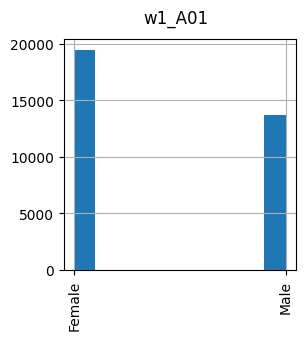

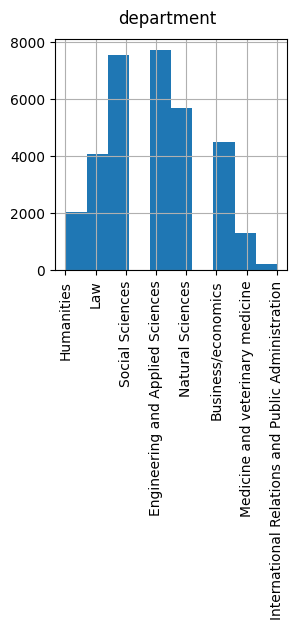

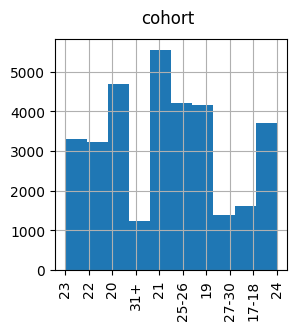

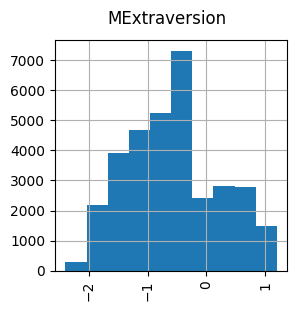

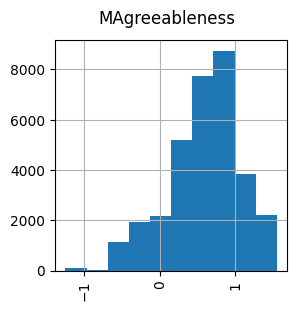

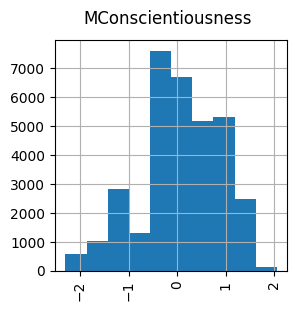

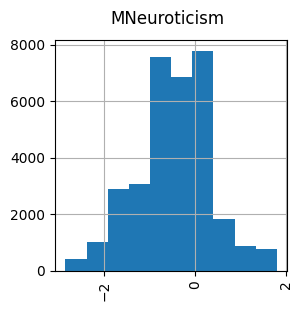

In [39]:
for i in ['w1_A01', 'department','cohort', 'MExtraversion', 'MAgreeableness', 'MConscientiousness', 'MNeuroticism']:
    fig = plt.subplots(figsize=(3,3))
    df[(df.withw != 'Alone') & (df.withw != 'No information') & (df.withw != 'Not answer')][f'{i}'].hist()
    plt.suptitle(f'{i}')
    plt.xticks(rotation=90)
    plt.show()
    

In [94]:
df.touches.median

<bound method Series.median of 0            0
1            0
2            0
3            0
4            0
          ... 
132235    1258
132236     903
132237     823
132238    1191
132239     814
Name: touches, Length: 132240, dtype: int64>

/tmp/ipykernel_5271/145363189.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.scatterplot(data=df.groupby('cohort').agg({'touches':'mean'}), x='cohort', y='touches')


<Axes: xlabel='cohort', ylabel='touches'>

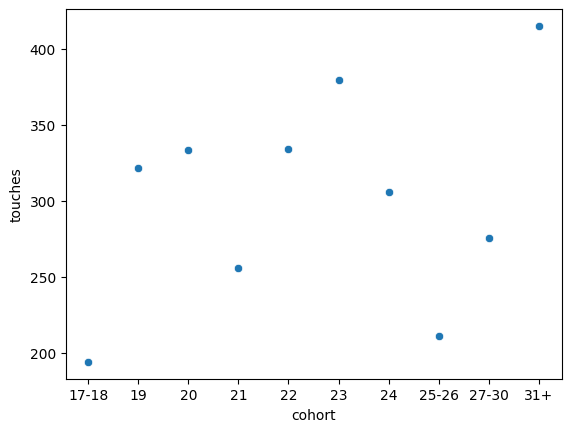

In [96]:
sns.scatterplot(data=df.groupby('cohort').agg({'touches':'mean'}), x='cohort', y='touches')

# Time series from clustering

(array([18579., 18581., 18583., 18585., 18587., 18589., 18591., 18593.,
        18595.]),
 [Text(18579.0, 0, '2020-11-13'),
  Text(18581.0, 0, '2020-11-15'),
  Text(18583.0, 0, '2020-11-17'),
  Text(18585.0, 0, '2020-11-19'),
  Text(18587.0, 0, '2020-11-21'),
  Text(18589.0, 0, '2020-11-23'),
  Text(18591.0, 0, '2020-11-25'),
  Text(18593.0, 0, '2020-11-27'),
  Text(18595.0, 0, '2020-11-29')])

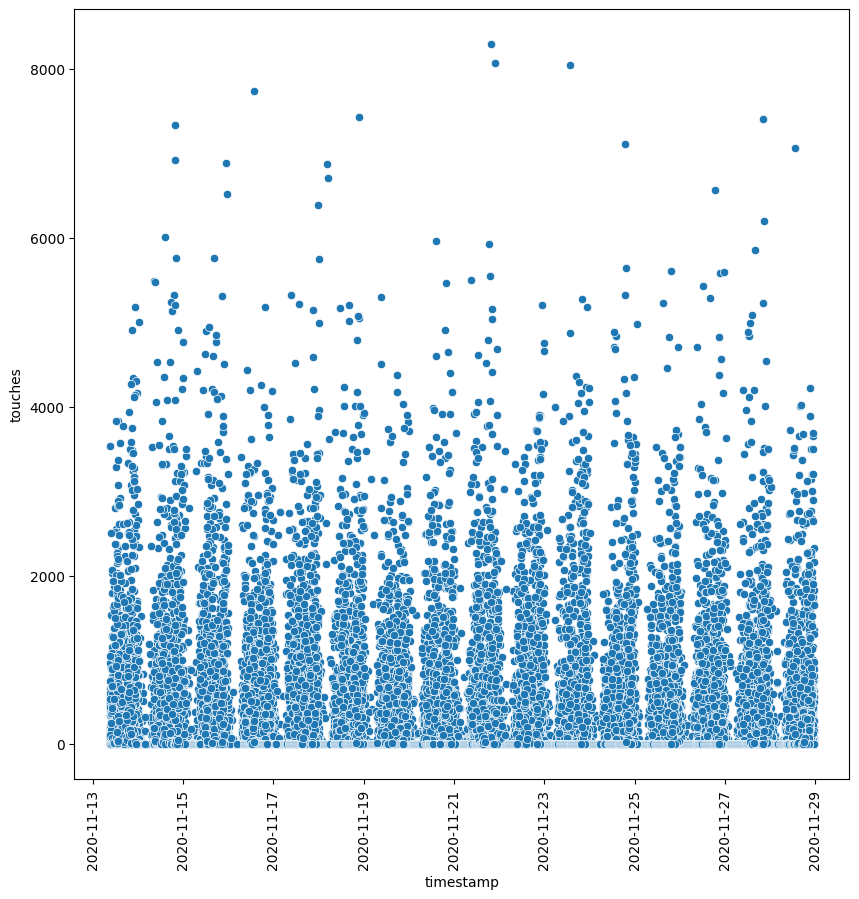

In [79]:
cluster_table = pd.read_csv('Processed Data/cluster_table.csv')
# Keep in mind: these "profiles" are clustered deriving from a subset of 33.126 observations
# regarding users who were WITH SOMEBODY, and dropped NAs.
cluster_table
with_somebody = df[(df.withw != 'Alone') & (df.withw != 'No information') & (df.withw != 'Not answer')]
plt.subplots(figsize=(10,10))
sns.scatterplot(data=with_somebody,
               x='timestamp',
               y='touches')
plt.xticks(rotation=90)

# Minute counts for user #1, Lecture days

In [ ]:
g = by_minute.copy()

g.loc[:,'using_phone'] = g['touches'] == 0
g.loc[:,'hour'] = g['timestamp'].dt.hour - 5
g.loc[:,'hour'] = [today_or_yesterday(hour) for hour in g['hour']]
g.loc[:, 'by_minute'] = g.loc[:,'hour'] + round(g.loc[:,'timestamp'].dt.minute/60, 3)
g

f = plt.figure(figsize=(7,5))
ax = f.add_subplot(1,1,1)
custom_order = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5]

sns.scatterplot(data=g[g['using_phone'] == True],
               x = 'day',
               y = 'hour'
             # palette=sns.color_palette(["#1e0f59", "#d4fbff"])
            )


ax.grid(axis='y')
plt.xticks(np.arange(len(custom_order)), custom_order)
plt.xlabel('Hour of the Day')
plt.ylabel('Frequency')
plt.title('Lecture days (Mon to Fri) for user #1: minutes with touching the smartphone screen', y=1.04)
plt.suptitle("the Y axis ticks are proportional to the total minutes in one hour", y=0.91, ha='center', fontsize=8)
# plt.legend()
plt.savefig('one_user_lectdays.png')
plt.show()

# Minute counts for user #1, Weekends

In [ ]:
g = by_minute[(by_minute.id==1) & (by_minute.day.isin(weekends))]

g['using_phone'] = g['touches'] >= 1 
g['hour'] = g['timestamp'].dt.hour - 5
g['hour'] = [today_or_yesterday(hour) for hour in g['hour']]

f = plt.figure(figsize=(7,5))
ax = f.add_subplot(1,1,1)

ax.hist([g['hour'][g['using_phone'] == 1], g['hour'][g['using_phone'] == 0]],
         
         bins=np.arange(-0.5, len(custom_order) - 0.5, 1),
         color=["#0893a1", "#b4d1d4"],
         edgecolor='white', stacked=True, label=['touchscreen events', 'no touchscreen event'])

n = g[g.hour == 10].shape[0]
plt.yticks([0, n/4,n/2, n-n/4, n])
ax.yaxis.set_major_formatter(mticker.PercentFormatter(n))
ax.grid(axis='y')
plt.xticks(np.arange(len(custom_order)), custom_order)
plt.xlabel('Hour of the Day')
plt.title('Weekends (Sat, Sun) for user #1: minutes with touching the smartphone screen', y=1.04)
plt.suptitle("the Y axis ticks are proportional to the total minutes in one hour", y=0.91, ha='center', fontsize=8)
plt.ylabel('Frequency')
plt.legend()
plt.savefig('one_user_weekends.png')
plt.show()

# Lecture days, but the minute counts represent all 147 users

In [ ]:
g = by_minute[~by_minute.day.isin(weekends)]
g['using_phone'] = g['touches'] == 0
g['hour'] = g['timestamp'].dt.hour - 5

g['hour'] = [today_or_yesterday(hour) for hour in g['hour']]
f = plt.figure(figsize=(7,5))
ax = f.add_subplot(1,1,1)
custom_order = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5]

ax.hist([g['hour'][g['using_phone'] == 0], g['hour'][g['using_phone'] == 1]],
         bins=np.arange(-0.5, len(custom_order) - 0.5, 1),
         edgecolor='white', stacked=True, label=['touchscreen events', 'no touchscreen event'],
        color=["#0893a1", "#b4d1d4"])
n = g[g.hour == 10].shape[0]
plt.yticks([0, n/4,n/2, n-n/4, n])
ax.yaxis.set_major_formatter(mticker.PercentFormatter(n))
ax.grid(axis='y')
plt.xticks(np.arange(len(custom_order)), custom_order)
plt.xlabel('Hour of the Day')
plt.ylabel('Frequency')
plt.title('Lecture days (Mon to Fri) for user #1: minutes with touching the smartphone screen', y=1.04)
plt.suptitle("the Y axis ticks are proportional to the total minutes in one hour", y=0.91, ha='center', fontsize=8)
plt.legend()
plt.savefig('all_users_lectdays.png')
plt.show()

# Weekends, but minute counts represent all users

In [ ]:
g = by_minute[by_minute.day.isin(weekends)]
g['using_phone'] = g['touches'] >= 1 
g['hour'] = g['timestamp'].dt.hour - 5
g['hour'] = [today_or_yesterday(hour) for hour in g['hour']]
f = plt.figure(figsize=(7,5))
ax = f.add_subplot(1,1,1)
ax.hist([g['hour'][g['using_phone'] == 1], g['hour'][g['using_phone'] == 0]],
        bins=np.arange(-0.5, len(custom_order) - 0.5, 1), color=["#0893a1", "#b4d1d4"], 
        edgecolor='white', stacked=True, label=['touchscreen events', 'no touchscreen event'])
n = g[g.hour == 10].shape[0]
plt.yticks([0, n/4,n/2, n-n/4, n])
ax.yaxis.set_major_formatter(mticker.PercentFormatter(n))
ax.grid(axis='y')
plt.xticks(np.arange(len(custom_order)), custom_order,rotation=90)
plt.xlabel('Hour of the Day')
plt.title('Weekends (Sat, Sun) for all users: minutes with touching the smartphone screen', y=1.04)
plt.suptitle("the Y axis ticks are proportional to the total minutes in one hour", y=0.91, ha='center', fontsize=8)
plt.ylabel('Frequency')
plt.legend()
plt.savefig('all_users_weekends.png')
plt.show()

# Population-level comparison between lecture days and weekends

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(9, 7), sharex=True)
ax1 = axes[0]
ax2 = axes[1]

#LECTURE DAYS:
g = by_minute[~by_minute.day.isin(weekends)]
g['using_phone'] = g['touches'] >= 1 
g['hour'] = g['timestamp'].dt.hour - 5
g['hour'] = [today_or_yesterday(hour) for hour in g['hour']]

ax1.hist([g['hour'][g['using_phone'] == 1], g['hour'][g['using_phone'] == 0]],bins=np.arange(-0.5, len(custom_order) - 0.5, 1), 
         color=["#0893a1", "#ffffff"], edgecolor='white', stacked=True, label=['touchscreen events', 'no touchscreen event'])
n = g[g.hour == 10].shape[0]

ax1.set_yticks(     [0, n*0.05, n*0.1, n*0.15, n*0.2, n/4, n*0.3, n/2, n*0.75, n])
ax1.set_yticklabels([' ', '5%','10%', '15%', '20%', '25%', '30%','50%', '75%', '100%'])
ax1.grid(axis='y')
ax1.set_title(f"Monday to Friday, n = {g.userid.unique().shape[0]}", y = 1)

ax1.set_ylim(0, n*0.3)


# WEEKENDS:
g = by_minute[by_minute.day.isin(weekends)]
g['using_phone'] = g['touches'] >= 1 
g['hour'] = g['timestamp'].dt.hour - 5
g['hour'] = [today_or_yesterday(hour) for hour in g['hour']]

ax2.hist([g['hour'][g['using_phone'] == 1], g['hour'][g['using_phone'] == 0]],bins=np.arange(-0.5, len(custom_order) - 0.5, 1), 
         color=["#0893a1", "#ffffff"], edgecolor='white', stacked=True, label=['touchscreen events', 'no touchscreen event'])
n = g[g.hour == 10].shape[0]

ax2.set_yticks([0, n*0.05, n*0.1, n*0.15, n*0.2, n/4, n*0.3, n/2, n-n/4, n])
ax2.set_yticklabels([' ', '5%','10%', '15%', '20%', '25%', '30%','50%', '75%', '100%'])
ax2.grid(axis='y')
ax2.set_title(f"Saturday and Sunday, n = {g.userid.unique().shape[0]}", y = -0.3)
ax2.set_xticks(np.arange(len(custom_order)))
ax2.set_xticklabels(custom_order)
ax2.set_xlim(-0.5, 23.5)

ax2.set_ylim(0, n*0.3)


plt.subplots_adjust(hspace=0.038, wspace=0.2)

plt.xlabel('Hour of the Day')
#plt.title('Weekends (Sat, Sun) for all users: minutes with touching the smartphone screen', y=1.04)
#plt.suptitle("the Y axis ticks are proportional to the total minutes in one hour", y=0.91, ha='center', fontsize=8)
plt.ylabel('Frequency')
plt.legend(loc='upper right', prop={'size': 7})
plt.savefig("test.png")
plt.show()

In [ ]:
for user in lectures_data.userid.unique():
    if user not in demographics.userid.unique():
        print(user)

In [ ]:
lectures_data = by_minute[~by_minute.day.isin(weekends)]
weekend_data = by_minute[by_minute.day.isin(weekends)]

In [ ]:
lectures_data[(lectures_data.userid == 1)].touches.sum()
g = lectures_data.groupby(by='userid').touches.agg('sum').sort_values().reset_index()
g.userid = g.userid.astype(str)
g
fig = plt.subplots(1, 1, figsize=(15,10))
sns.scatterplot(x='userid', y='touches', data=g)
plt.tick_params(axis='x', labelsize=5)
plt.xticks(rotation=90)

plt.show()


# Correlation Matrix
Before proceeding with any association phone usage. 